# FEniCS simulation of Eshelby's circular inclusion problem

Course MU5MES01

$\underline{\text{Students name}}$ : Valentin Duvivier & Marie Robin

$\underline{\text{Under the direction of}}$ : Corrado Maurini, Sebastien Neukirch, Denis Duhamel, Claire Lestringant
    
$\underline{\text{Last modified}}$ : 14/10/2021

$\underline{Abstract}$ : This report is part of the first report of the Finite Element course MU5MES01. It's conducted in order to study numerically an Eshelby circular inclusion problem, derive the displacement field from it and study the convergence of the numerical scheme.

It has been done excluesively by Valentin Duvivier and Marie Robin, and so we engage ourselves by confirming that no part of the following have been plagiarized in anyway.

## Plan Notebook report

$\hspace{1cm}$I. Eshelby problem, the disk inclusion

$\hspace{2cm}$ a. Framework

$\hspace{2cm}$ b. Weak and variational formulations

$\hspace{1cm}$II. Solve elasticity problem

$\hspace{2cm}$ a. Discretization

$\hspace{2cm}$ b. Implementation weak formulation

$\hspace{2cm}$ c. Solving

$\hspace{1cm}$III. Post-process

$\hspace{2cm}$ a. Strain

$\hspace{2cm}$ b. Limit cases / convergence rate 

$\hspace{3cm}$ i. Materials

$\hspace{4cm}$ 1. Dependency $\nu$

$\hspace{4cm}$ 2. Dependency $E$ ratio

$\hspace{3cm}$ ii. Geometry

$\hspace{4cm}$ 1. Dependency radii ratio

$\hspace{4cm}$ 2. Dependency shape inclusion

## I. Eshelby problem, the disk inclusion

### a. Framework

$\underline{\text{Domain}}$ : the domain is 2D, circular such that 
$$ r \in [0, R_{out}], ~~ \theta \in [0, 2\pi]$$

We furthermore consider an inclusion in this domain : 
$$r_{int} \in [0, R_{in}], ~~ \theta \in [0, 2\pi]$$

$\underline{\text{System}}$ : the system is linear elastic, and is made of two materials which don't share same young modulus and shear stress coefficient ($E$, $\nu$).

Then, eventhough both materials don't share same elastic characteristics, they are both homogeneous and isotropic in their respective domain.

$\underline{\text{Equations/Hypotheses}}$ : we assume plane strain elasticity such that :
$$\underline{\underline{\epsilon}} = \underline{\underline{\epsilon}}^{2D} = \begin{bmatrix}
                                 \epsilon_{11} & \epsilon_{12} \\
                                 \epsilon_{21} & \epsilon_{22}
                             \end{bmatrix}$$
                             
It comes $$\underline{\underline{\sigma}}^{2D} = \dfrac{E}{1-\nu^2}\left((1-\nu)\underline{\underline{\epsilon}}^{2D} + \nu.tr\left(\underline{\underline{\epsilon}}^{2D} \right) \right)$$

Besides, we consider the system is under static equilibrium, namely $\underline{div}(\underline{\underline{\sigma}}) = \underline{0} ~~ \forall \underline{x} \in \Omega$ ; and little perturbation, namely $\underline{\underline{\epsilon}} = sym\underline{\underline{\nabla}}\underline{u} ~~ \forall \underline{x} \in \Omega$.

Some elements describing the problem are sumarrized in the following figure :

![shema](./inclusion_shear.png)

Now that the framework is defined, let's states the problem we want to solve, using the variational formulation of equilibrium.

### b. Weak and variational formulation

First, here is the weak formulation of the problem :

Find $\underline{u}\in \mathcal{C}\equiv\{\underline{u}: H^1(\Omega), \; u(x_1,x_2)|_{x_1^2+x_2^2=R_m^2}
%\text{border}
=(-x_2,-x_1)\}$ such that 
$\forall \underline{v}\in \mathcal{C}_0\equiv \mathcal{C}$


\begin{equation}
\int_\Omega \underline{\underline{\sigma}}\left(\underline{\underline{\varepsilon}}(\underline{u})\right):\underline{\underline{\varepsilon}}(\underline{v})\,\mathrm{d}x\,\mathrm{d}y =
\int_{\Omega} \underline{b} \cdot \underline{v}\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

where the body force $b=0$ and $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$

This weak formulation is equivalent to the variational formulation defined by :
    
to find $u \in C$ such that :
    
$$I(u) < I(v) ~~ \forall v \in C_0$$

or equivalently

$$I'(u)(v) = 0 ~~ \forall v \in C_0$$

with \begin{equation}
I(u) = \int_\Omega \underline{\underline{\varepsilon}}(\underline{u}):\underline{\underline{\underline{\underline{A}}}}:\underline{\underline{\varepsilon}}(\underline{u})\,\mathrm{d}x\,\mathrm{d}y -\int_{\Omega} \underline{b} \cdot \underline{u}\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

This definition of the variational formulation tells us that **the system is under equilibrium under no external stress nor volumic forces as b=0)**.

From the **kinematically admissible field**, one can see we apply a **boundary condition of displacement on the outer edge** $\partial \Omega_u = \partial \Omega$. We thus are in a **type 1 problem** that is **exact in displacement** (provided one fixes center of domain) **and stress**.
The problem thus is well defined and will lead to consistent results on the displacement and stress fields.**

Now that the problem is set, let's solve it numerically using dolfin/FEniCS libraries.

## II. Code

#### Libraries

In [1]:
import dolfin
import matplotlib.pyplot as plt
import mshr
import numpy as np

#### Domain

In [39]:
# ----------
# geometric
# ----------

R_i  = 1.0 # radius of the inclusion
R_m  = 3.9 # radius of the outer matrix

# ----------
# material
# ----------

# inner circle
E_i  = 11.0 # Young's modulus for the inclusion
nu_i =  0.3 # Poisson ratio for the inclusion

# outter circle
E_m  = 0.80 # Young's modulus for the matrix
nu_m = 0.35 # Poisson ratio for the matrix

# ---------------- 
# equivalent

# outer matrix
mu_m   = E_m / (2 * (1 + nu_m))
lamb_m = 2 * mu_m * nu_m / (1 - 2*nu_m)

# inner matrix
mu_i   = E_i / (2 * (1 + nu_i))
lamb_i = 2 * mu_i * nu_i / (1 - 2*nu_i)

# ---------------------
# discretization in FE
# ---------------------

h = 0.35 * R_i # Size of elements

# associate each subdomain to a number
ONE = dolfin.Constant(1.)

MATRIX_ID    = 1 # outer domain
INCLUSION_ID = 2 # inclusion

# ----------------------

# perimeters
L_i = 2 * np.pi * R_i # perimeter of the inclusion
L_m = 2 * np.pi * R_m # perimeter of the outer domain

# nb segments
N_i = int(L_i/h)  # number of mesh points on the perimeter 
                     # of the inclusion

N_m = int(L_m/h) # number of mesh points on the perimeter 
                     # of the outer domain

### a. Discretization

#### Numerical domain

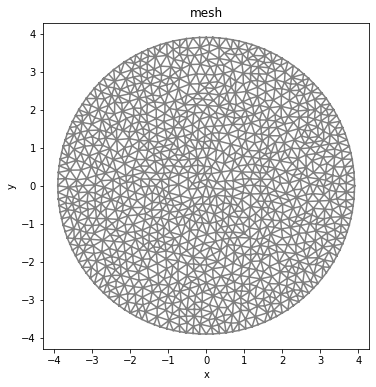

In [40]:
# We create the mesh and the subdomains composing it.

# ------------------
# numerical domain
# ------------------

origin  = dolfin.Point(0., 0.) # set center of circular domain

Omega_i = mshr.Circle(origin, R_i, segments=N_i  ) # inner space
Omega   = mshr.Circle(origin, R_m, segments=N_m  ) # overall space

Omega.set_subdomain(INCLUSION_ID ,        Omega_i) # we are putting tags in parts of the mesh
Omega.set_subdomain(MATRIX_ID    ,  Omega-Omega_i) # we will use them later

# --------------
# meshes

mesh = mshr.generate_mesh(Omega, resolution=2*R_m/h)

subdomain_data_2d = dolfin.MeshFunction("size_t", # the function returns a positive integer
                                        mesh,     # it is defined over the entire mesh
                                        dim=2,    # the function is defined on the cells (not edges nor vertices)
                                        value=mesh.domains() # the function value is in fact
                                                             # given by the tag we have put while creating the mesh
                                       )
# space step
dx = dolfin.Measure("dx", domain=mesh, subdomain_data=subdomain_data_2d)

# --------------
# Display mesh

plt.figure(figsize=(6,6))

dolfin.plot(mesh)

plt.title('mesh')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

The mesh is no different in the inner and the outer zones. Then, on both zones, it's made of T3 elements homogeneously distributed over the domain.

We then work on a 2D domain using linear elements.

#### Finite element discretization

As part of the finite element theory, we look for a discretization under the form :
    
$$\underline{u} = \sum_{i=1}^N u_i \phi_i$$

One then must define the set of basis functions $\phi$ he wants to work with, to better approach the displacement field.

In our case, **we consider** as mentionned before **2D linear element (i.e. T3 basis functions)**.

In [41]:
# We define the basis functions - VectorElement as u=(u, v)

element = dolfin.VectorElement('P',                  # use Lagrange family ??
                               cell=dolfin.triangle, # use triangle cells
                               degree=1,             # returns linear element if degree=1
                               dim=2)                # 2D elements if dim=2

# ------
# Set of basis functions

V = dolfin.FunctionSpace(mesh, element)

# ------
# We initialize trial and test functions from it

u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

### b. Implementation weak formulation

We here below develop functions associated to elements of the weak formulation problem.

In [42]:
# sigma(eps(u))

def stress(eps, lamb, mu):
    
    """ Function returning 2D stress tensor under the assumption of plane strain hypothesis ; given data eps, lamb, mu. """
    
    sig = lamb * dolfin.tr(eps) * dolfin.Identity(2) + 2*mu * eps
    
    return sig

# eps(u)

# --------------

def strain(u):
    
    """ Function returning the 2D strain tensor under the assumption of plane strain hypothesis ; given datum displacement field u. """
    
    eps = .5 * (dolfin.grad(u) + dolfin.nabla_grad(u))
#     eps = dolfin.sym(dolfin.grad(u)) # equivalent form
    
    return eps

#### Bilinear/linear forms

\begin{equation}
\int_\Omega \underline{\underline{\sigma}}\left(\underline{\underline{\varepsilon}}(\underline{u})\right):\underline{\underline{\varepsilon}}(\underline{v})\,\mathrm{d}x\,\mathrm{d}y =
\int_{\Omega} \underline{b} \cdot \underline{v}\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

In [43]:
# The system comprises two subdomains. The total bilinea and 
# linear form are the addition of integrals on each subdomain.

# ---------
# Bilinear
# ---------

# inner
eps_u = strain(u)
sig_i = stress(eps_u, lamb_i, mu_i)

# outter
eps_v = strain(v)
sig_m = stress(eps_u, lamb_m, mu_m)

# assembly
a_i = dolfin.inner(sig_i, eps_v)*dx(INCLUSION_ID)
a_m = dolfin.inner(sig_m, eps_v)*dx(MATRIX_ID)

# -----

bilinear_form = a_i + a_m

# -------
# Linear
# -------

b = 0
f = dolfin.Constant((0, b))
linear_form = dolfin.dot(f, v) * dolfin.dx

#### Boundary conditions

$$u(x_1,x_2)=(-x_2,-x_1) ~~ \forall \underline{x} \in \partial \Omega \equiv \partial \Omega_u$$

In [44]:
# boundary condition function
u_D = dolfin.Expression(('-x[1]', '-x[0]'), degree=1) # degree 1 as linear function

# boundary automatically returned
def boundary(x, on_boundary):
    
    """ Function returning outer boundary. """
        
    return on_boundary

# apply BC from basis functions in V (it gives outer edge)
boundary_conditions = dolfin.DirichletBC(V, u_D, boundary)

### c. Solving

In [45]:
# we note usol the solution
usol = dolfin.Function(V)

dolfin.solve(bilinear_form == linear_form, usol, boundary_conditions)

#### Display displacement field

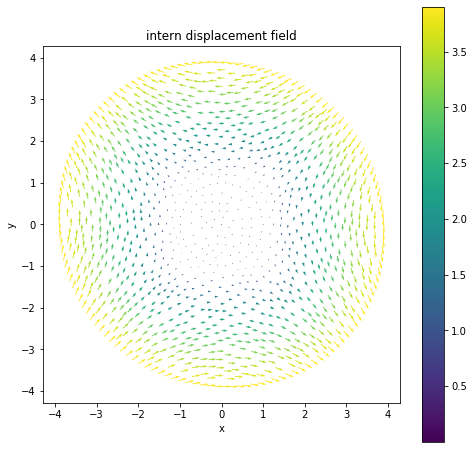

In [46]:
# plot with colorbar

plt.figure(figsize=(8,8))

plt.colorbar(dolfin.plot(usol))

plt.title('intern displacement field')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

This graph shares the shape of the displacement field presented in the introduction, except it's here the intern displacement.

**We thus confirm the problem has been well computed given it reproduces well the displacement field from BC**.

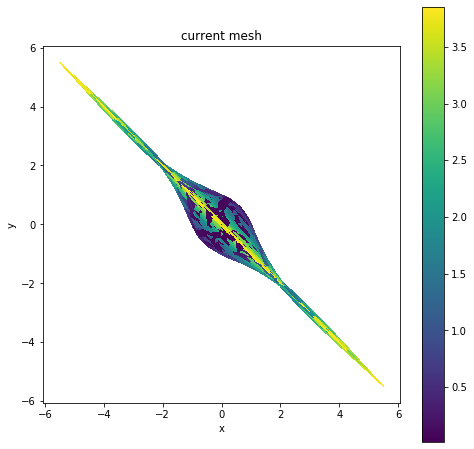

In [47]:
# solution in displacement

plt.figure(figsize=(8,8))

plt.colorbar(dolfin.plot(usol, mode='displacement'))

plt.title('current mesh')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

We can see the structure suffered a deformation due to the imposed displacement on the outer edge. We then compressed the structure on one diagonal and elongated it along the other diagonal.

At this stage **we solved the weak formulation problem** and **obtained** the **displacement field**. We now would like to make sure these results are consistent with respect to the **analytical solution** and measure **how consistent the numerical scheme is**.

## III. Post process

### a. Strain

To remain consistent in our modelization, as we had a basis of linear elements for the displacement, we must have elements of degree zero for the strain field.

We then must define a new set of elements that are still triangles elements but of degree 0 (for projection to be consistent we keep same functions but change degree). Besides, we must here account for non-linearities between the subdomains for solving to converge.


      Strain inside system


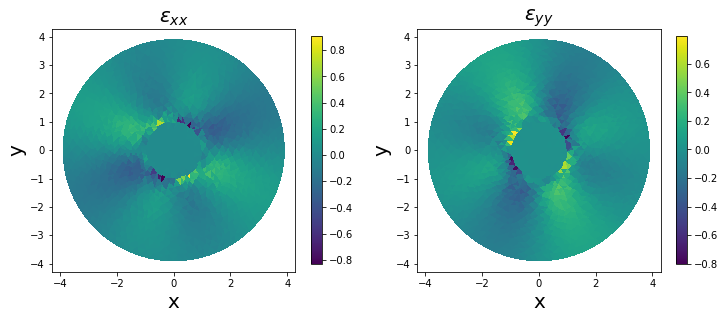

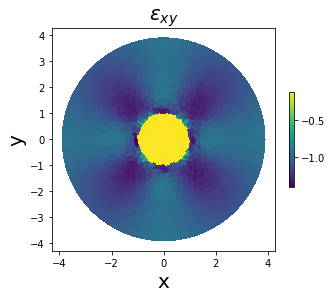

In [48]:
# New basis functions - degree=0

E_project = dolfin.FiniteElement('DG', cell=dolfin.triangle, degree=0)
V_project = dolfin.FunctionSpace(mesh, E_project)

eps = dolfin.sym(dolfin.grad(usol))

# project strain components into the new basis
eps_xx = dolfin.project(eps[0,0], V_project)
eps_xy = dolfin.project(eps[0,1], V_project) #==eps_plot_yx
eps_yx = dolfin.project(eps[1,0], V_project) #==eps_plot_yx
eps_yy = dolfin.project(eps[1,1], V_project)

# ------------------------------------------------

def plot_eps(eps, text):

    """ Function returning the plot of a function given the function and the title under the form : plot_eps(function, 'title') """
    
    plt.colorbar(dolfin.plot(eps), shrink=0.35)

    plt.title(text, size=20)
    plt.xlabel('x', size=20)
    plt.ylabel('y', size=20)

from pylab import *

plt.figure(figsize=(12,12))

subplot(1,2,1)
plot_eps(eps_xx, '$\epsilon_{xx}$')

subplot(1,2,2)
plot_eps(eps_yy, '$\epsilon_{yy}$')

plt.figure(figsize=(5,5))
plot_eps(eps_xy, '$\epsilon_{xy}$')

print('\n      Strain inside system')

It looks like the inner domain (i.e. the inclusion) is homogeneous while the outer domain (i.e. matrix) presents anisotropy due to BC. As we work on a discontinuous system, the strain of inner domain doesn't share same properties than the one of the outer domain.

Let's see characterize homogeneousness of the domains by calculating their deviation (i.e. variance) :

\begin{equation}
\frac{\int_\Omega |\varepsilon_{ij} - <\varepsilon_{ij}>|  }{ <\varepsilon_{ij}> }\,\mathrm{d}x\,\mathrm{d}y
\end{equation}

In [49]:
def average_strain(eps, dx, subdomain):
    
    """ Function returning the average strain given the strain tensor and the integration domain, and precision of subdomain. """

    mean_eps = dolfin.assemble(eps*dx(subdomain)) / dolfin.assemble(ONE*dx(subdomain))
    
    return mean_eps

def deviation(eps, dx, subdomain):
    
    """ Function returning deviation of the strain. """
    
    numerator   = np.abs(eps - average_strain(eps, dx, subdomain))*dx(subdomain)
    denominator = average_strain(eps, dx, subdomain)
    
    return dolfin.assemble(numerator) / denominator

# print(deviation(eps[0,0], dx, INCLUSION_ID))
print('\nAbsolute of deviation of \u03B5_xy = {:.3f}'.format(np.abs(deviation(eps[0,1], dx, INCLUSION_ID))))
# print(deviation(eps[1,1], dx, INCLUSION_ID))


Absolute of deviation of ε_xy = 0.081


The lower the better for the variance and the value we obtain here tells us the inner domain has a low variance, which translates the fact values of shearing stress inside the inclusion is close to the mean value all over the domain (i.e. quiet homogeneous domain).

We then observe that when one applies a shearing like BC, the inner domain remains homogeneous contrary to the outer domain. We yet highlight that this is true for the consideration of materials used above and that it may vary for other materials.

**To work furthermore on this point, we see the link between matrials and system's properties and results of the numerical scheme. Especially, we will look at such dependancy in the study of convergence.**

To deal with the convergence rate calculation, we consider an analytical solution that one derived inside eshelby module.

In [50]:
from eshelby import EshelbyDisk

solution = EshelbyDisk(R_m/R_i, E_i/E_m, nu_i, nu_m)
u_ref    = solution.to_expression(R_i)

# Execute this to obtain the plot of the analytical solution
V_ref     = dolfin.VectorFunctionSpace(mesh, 'P', 1)
u_ref_num = dolfin.interpolate(u_ref, V_ref)

In [51]:
# L2 error
e_L2 = dolfin.errornorm(u_ref_num, usol, "L2")
print(e_L2*100)
print('We see the analytical solution reproduces well the values we obtained numerically')

1.5931734327183378
We see the analytical solution reproduces well the values we obtained numerically


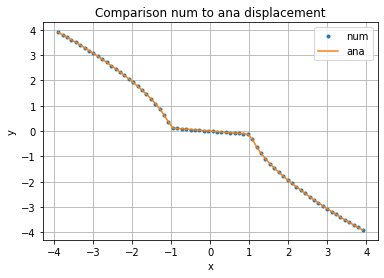

In [52]:
x     = np.linspace(-R_m, R_m, num=N_m)
v_num = np.array([usol(_,0)      for _ in x]) #from dolfin to array
v_ana = np.array([u_ref_num(_,0) for _ in x]) #from dolfin to array

plt.plot(x, v_num[:,1], '.', x, v_ana[:,1], '-')

plt.title('Comparison num to ana displacement')
plt.xlabel('x')
plt.ylabel('y')

plt.legend(['num', 'ana'])
plt.grid(True)

One can see the mean line deforms in the expected direction. What was not so expected is the fact the displacement at center is constant. We thus observe a discontinuity with 2 distincs phase of displacement.

The analytical solution is using radii ratio and Young moduli ratio as entry parameters as well as $\nu$ values.

In this sense, we will look for the behavior of numerical code when varying these 3 parameters, the reliability of eshelby solution and the numerical consistence of results (convergence, convergence rate).

### b. Convergence rate

Loop below allows to calculate usol in a point and stock the values for different space step and varying parameters.

In the end we calculate convergence rate from it.

In [53]:
import scipy.optimize as optimization

def func(x, a, b):
   
    """ Function returning num fit for y=a*x curve. """
    
    return a * x + b

##### Loop code (does not provide values displayed below as too long otherwise)

In [88]:
# linear element
element = dolfin.VectorElement('P',                  # use Lagrange family ??
                               cell=dolfin.triangle, # use triangle cells
                               degree=1,             # returns linear element if degree=1
                               dim=2)                # 2D elements if dim=2

# # quadratic element
# element = dolfin.VectorElement('P',                  # use Lagrange family ??
#                                cell=dolfin.triangle, # use triangle cells
#                                degree=2,             # returns quadratic element if degree=2
#                                dim=2)                # 2D elements if dim=2

# ---------------------
# discretization in FE
# ---------------------

# space steps
Delta_x        = np.array([2**(-_) for _ in range(2, 7)]) * R_i

# kinetic viscosity for uncompressible limit case
kin_visc    = np.array([0.3, 0.35, 0.4, 0.45, 0.4999])

# L2 & H1 errors
error_stock_L2 = np.zeros(( np.size(Delta_x), np.size(kin_visc) ))
error_stock_H1 = np.zeros(( np.size(Delta_x), np.size(kin_visc) ))

print('Code processing ...')

for i in range(np.size(Delta_x)):
    for j in range(np.size(kin_visc)):

        # ---------------------------------
        # ---------------------------------
        #                DATA
        # ---------------------------------
        # ---------------------------------

        # ----------
        # geometric
        # ----------

        R_i  = 1.0 # radius of the inclusion
        R_m  = 3.9 # radius of the outer matrix

        # ----------
        # material
        # ----------

        # inner circle
        E_i  = 11.0 # Young's modulus for the inclusion
        nu_i = 0.30 # Poisson ratio for the inclusion

        # outter circle
        E_m  = 0.80 # Young's modulus for the matrix
        nu_m = kin_visc[j] # Poisson ratio for the matrix

        # ---------------- 
        # equivalent

        # outer matrix
        mu_m   = E_m / (2 * (1 + nu_m))
        lamb_m = 2 * mu_m * nu_m / (1 - 2*nu_m)

        # inner matrix
        mu_i   = E_i / (2 * (1 + nu_i))
        lamb_i = 2 * mu_i * nu_i / (1 - 2*nu_i)

        # ---------------------------------
        # ---------------------------------
        #              Space step
        # ---------------------------------
        # ---------------------------------

        h = Delta_x[i] # Size of elements

        # nb segments
        N_i = int(L_i/h) # number of mesh points on the perimeter 
                         # of the inclusion

        N_m = int(L_m/h) # number of mesh points on the perimeter 
                         # of the outer domain

        # ---------------------------------
        # ---------------------------------
        #                 Code
        # ---------------------------------
        # ---------------------------------

        # We create the mesh and the subdomains composing it.

        # ------------------
        # numerical domain
        # ------------------

        origin  = dolfin.Point(0., 0.) # set center of circular domain

        Omega_i = mshr.Circle(origin, R_i, segments=N_i  ) # inner space
        Omega   = mshr.Circle(origin, R_m, segments=N_m  ) # overall space

        Omega.set_subdomain(INCLUSION_ID ,        Omega_i) # we are putting tags in parts of the mesh
        Omega.set_subdomain(MATRIX_ID    ,  Omega-Omega_i) # we will use them later

        # --------------
        # meshes

        mesh = mshr.generate_mesh(Omega, resolution=2*R_m/h)

        subdomain_data_2d = dolfin.MeshFunction("size_t", # the function returns a positive integer
                                                mesh,     # it is defined over the entire mesh
                                                dim=2,    # the function is defined on the cells (not edges nor vertices)
                                                value=mesh.domains() # the function value is in fact
                                                                     # given by the tag we have put while creating the mesh
                                               )
        # space step
        dx = dolfin.Measure("dx", domain=mesh, subdomain_data=subdomain_data_2d)

        # --------------
        # Set of basis functions

        V = dolfin.FunctionSpace(mesh, element) # element already defined

        u = dolfin.TrialFunction(V)
        v = dolfin.TestFunction(V)

        # ------------------------------------------------------------ #
        # ------------------------------------------------------------ #

        # ---------
        # Bilinear
        # ---------

        # inner
        eps_u = strain(u)
        sig_i = stress(eps_u, lamb_i, mu_i)

        # outter
        eps_v = strain(v)
        sig_m = stress(eps_u, lamb_m, mu_m)

        # assembly
        a_i = dolfin.inner(sig_i, eps_v)*dx(INCLUSION_ID)
        a_m = dolfin.inner(sig_m, eps_v)*dx(MATRIX_ID)

        # -----

        bilinear_form = a_i + a_m

        # -------
        # Linear
        # -------

        b = 0
        f = dolfin.Constant((0, b))
        linear_form = dolfin.dot(f, v) * dolfin.dx

        # ---
        # BC
        # ---

        boundary_conditions = dolfin.DirichletBC(V, u_D, boundary)

        # ------------------------------------------------------------ #
        # ------------------------------------------------------------ #

        usol = dolfin.Function(V)

        dolfin.solve(bilinear_form == linear_form, usol, boundary_conditions)

        # epsilon_xy :
#
#         epsilonnne = dolfin.sym(dolfin.grad(usol))[1,0]
#         deviation_stock[j] = deviation(epsilonnne, dx, INCLUSION_ID)

        # stock errors
        error_stock_L2[i,j] = dolfin.errornorm(u_ref, usol, "L2")
        error_stock_H1[i,j] = dolfin.errornorm(u_ref, usol, "H1")
        
        print(1)
    print(2)
print('Finished')

Code processing ...
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
2
Finished


#### Save values

In [55]:
# np.savetxt('csv FEniCS/errors/error_nu_i_L2.txt', error_stock_L2, fmt='%.4f')
# np.savetxt('csv FEniCS/errors/error_radius_H1.txt', error_stock_H1, fmt='%.4f')

#### Interpolate conv rate

In [57]:
import scipy.optimize as optimization

a = np.zeros((np.size(error_stock_L2, 1)))

for i in range(np.size(error_stock_L2, 1)):
    kk   = optimization.curve_fit(func, np.log(Delta_x), np.log(error_stock_L2[:,i]))[0][0]
    a[i] = np.array([kk])
# np.savetxt('csv FEniCS/convergence/conv_rate_radius_L2.txt', a, fmt='%.4f')

# --------

a = np.zeros((np.size(error_stock_H1, 1)))

for i in range(np.size(error_stock_H1, 1)):
    kk   = optimization.curve_fit(func, np.log(Delta_x), np.log(error_stock_H1[:,i]))[0][0]
    a[i] = np.array([kk])
# np.savetxt('csv FEniCS/convergence/conv_rate_radius_H1.txt', a, fmt='%.4f')

#### Import values conv rate

In [58]:
# ----------------------
# deviation ratio radii
# ----------------------

filename = 'csv FEniCS/strain/variance_radii.txt'
dev_strain_radii = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# --------------------
# conv rate nu values
# --------------------

# nu_i
filename = 'csv FEniCS/convergence/conv_rate_nu_i_L2.txt'
conv_rate_L2_i = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# nu_i
filename = 'csv FEniCS/convergence/conv_rate_nu_i_H1.txt'
conv_rate_H1_i = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# ------

# nu_m
filename = 'csv FEniCS/convergence/conv_rate_nu_m_L2.txt'
conv_rate_L2_m = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# nu_m
filename = 'csv FEniCS/convergence/conv_rate_nu_m_H1.txt'
conv_rate_H1_m = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# -------------------
# conv rate E values
# -------------------

filename = 'csv FEniCS/convergence/conv_rate_ymodulus_L2.txt'
conv_rate_L2_y = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# ------

filename = 'csv FEniCS/convergence/conv_rate_ymodulus_H1.txt'
conv_rate_H1_y = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# ---------------------------
# linear/quadratic conv rate
# ---------------------------

filename = 'csv FEniCS/convergence/conv_rate_linear_element_L2.txt'
conv_rate_linear_L2 = np.loadtxt(filename, delimiter=',', skiprows=1, dtype=float)

# ------

filename = 'csv FEniCS/convergence/conv_rate_linear_element_H1.txt'
conv_rate_linear_H1 = np.loadtxt(filename, delimiter=',', skiprows=1, dtype=float)

# ------

filename = 'csv FEniCS/convergence/conv_rate_quadratic_element_L2.txt'
conv_rate_quadratic_L2 = np.loadtxt(filename, delimiter=',', skiprows=1, dtype=float)

# ------

filename = 'csv FEniCS/convergence/conv_rate_quadratic_element_H1.txt'
conv_rate_quadratic_H1 = np.loadtxt(filename, delimiter=',', skiprows=1, dtype=float)

#### Import values $L_2$ and $H_1$ errors

In [90]:
# -----------------
# errors nu values
# -----------------

# nu_i
filename = 'csv FEniCS/errors/conv_data_nu_i_L2.txt'
conv_data_L2_i = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# nu_i
filename = 'csv FEniCS/errors/conv_data_nu_i_H1.txt'
conv_data_H1_i = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# ------

# nu_m
filename = 'csv FEniCS/errors/conv_data_nu_m_L2.txt'
conv_data_L2_m = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# nu_m
filename = 'csv FEniCS/errors/conv_data_nu_m_H1.txt'
conv_data_H1_m = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# -------------------
# conv rate E values
# -------------------

filename = 'csv FEniCS/errors/conv_data_ymodulus_L2.txt'
conv_data_L2_y = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

# ------

filename = 'csv FEniCS/errors/conv_data_ymodulus_H1.txt'
conv_data_H1_y = np.loadtxt(filename, delimiter=' ', skiprows=0, dtype=float)

#### Graphic showing conv rate

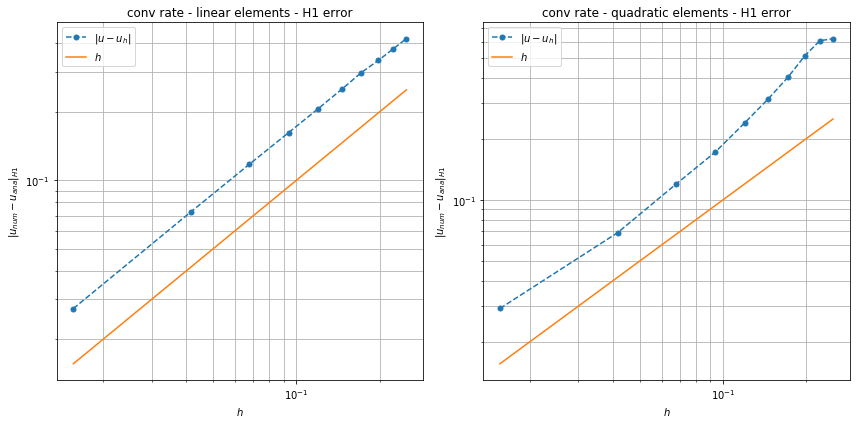

In [91]:
# Plot conv rate

plt.figure(figsize=(12,6))

Delta_x        = np.linspace(2**-6, 2**-2, 10) * R_i # can't change these values

subplot(1,2,1)
plt.loglog(Delta_x, conv_rate_linear_H1, '.--', markersize=10, label=r'|$u-u_h$|')
plt.loglog(Delta_x, Delta_x, label=r'$h$')

plt.title('conv rate - linear elements - H1 error')
plt.ylabel(r'$|u_{num} - u_{ana}|_{H1}$')
plt.xlabel(r'$h$')

plt.grid(True, which="both")
plt.legend()

# ----------------------------

subplot(1,2,2)
plt.loglog(Delta_x, conv_rate_quadratic_H1, '.--', markersize=10, label=r'|$u-u_h$|')
plt.loglog(Delta_x, Delta_x, label=r'$h$')

plt.title('conv rate - quadratic elements - H1 error')
plt.ylabel(r'$|u_{num} - u_{ana}|_{H1}$')
plt.xlabel(r'$h$')

plt.grid(True, which="both")
plt.legend()

# ------

plt.tight_layout()

plt.show()

We see above code indeed allows to calculate convergence rate. We then observe that the liniear element numerical scheme is of order 1. Similarly, quadratic elements lead to a conv rate of 1. It is in fact due to the fact we here try to increase precision of numerical scheme but we are in fact limited by the mesh partially defined from linear elements anyway (e.g. perimeter).

### c. Limit cases

#### i. Materials

In this part, we test behavior of numerical solution for different values of $\nu$ and ratio $E$.

##### $\nu$ value

In [92]:
# adapt L2 error

tol = 1E-7

a   = conv_rate_L2_i
idx = np.where(a > 1+tol)
conv_rate_L2_i[idx] -= 1

# --------

b   = conv_rate_L2_m
idx = np.where(b > 1+tol)
conv_rate_L2_m[idx] -= 1

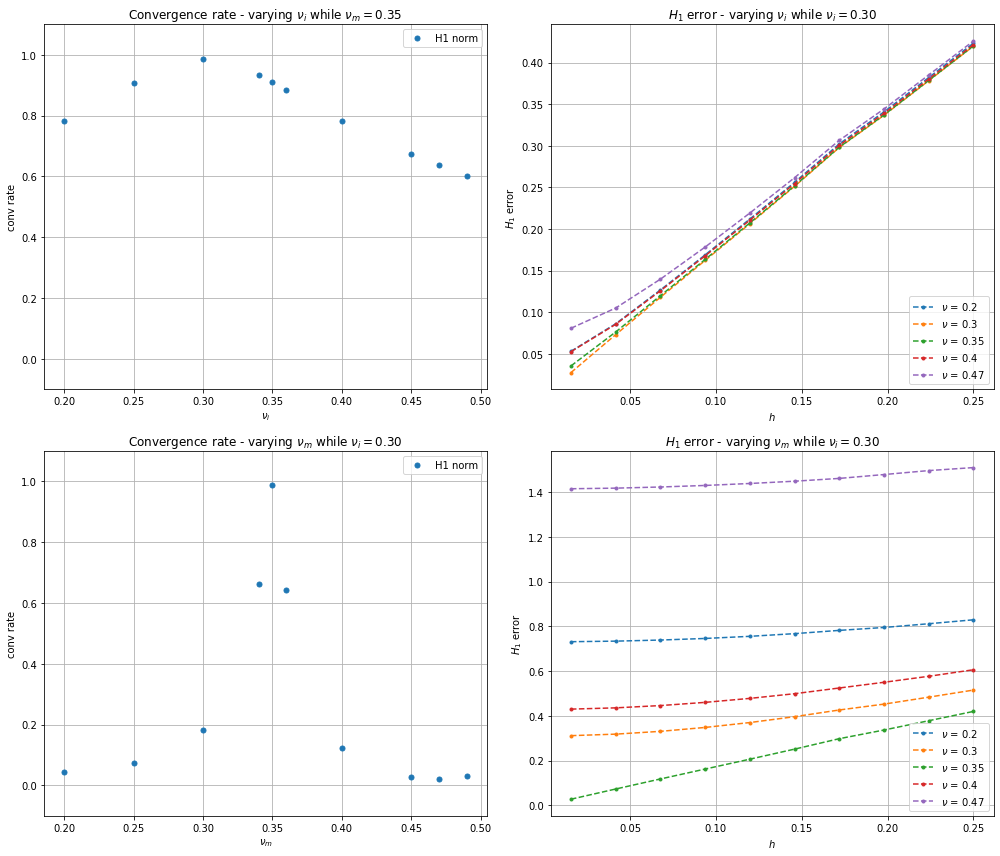

In [141]:
# plot conv rate numerical method as a function of radii ratios

plt.figure(figsize=(14,12))
    
kin_visc       = np.array([0.20, 0.25, 0.30, 0.34, 0.35, 0.36, 0.40, 0.45, 0.47, 0.49]) # can't change these values

plt.subplot(2,2,1)
# plt.plot(kin_visc, conv_rate_L2_i, ' ', marker='o', markersize=10, markerfacecolor='none', label='L2 norm')
plt.plot(kin_visc, conv_rate_H1_i, '.', markersize=10, label='H1 norm')

plt.title(r'Convergence rate - varying $\nu_i$ while $\nu_m=0.35$')
plt.xlabel(r'$\nu_i$')
plt.ylabel('conv rate')

plt.ylim(-.1, 1.1)

plt.grid(True)
plt.legend()

# ---------------

plt.subplot(2,2,2)
# plt.plot(Delta_x, conv_data_L2_i, ' ', marker='o', markersize=10, markerfacecolor='none', label='L2 norm')
for i in range(np.size(conv_data_H1_i[:,0::2],1)):
    plt.plot(Delta_x[:], conv_data_H1_i[:,2*i], '.--', label=r'$\nu$ = {}'.format(kin_visc[2*i]))

plt.title(r'$H_1$ error - varying $\nu_i$ while $\nu_i=0.30$')
plt.xlabel(r'$h$')
plt.ylabel(r'$H_1$ error')

plt.grid(True)
plt.legend(loc=4)

# --------------------------------------------------------------------- #

plt.subplot(2,2,3)
# plt.plot(kin_visc, conv_rate_L2_m, ' ', marker='o', markersize=10, markerfacecolor='none', label='L2 norm')
plt.plot(kin_visc, conv_rate_H1_m, '.', markersize=10, label='H1 norm')

plt.title(r'Convergence rate - varying $\nu_m$ while $\nu_i=0.30$')
plt.xlabel(r'$\nu_m$')
plt.ylabel('conv rate')

plt.ylim(-.1, 1.1)

plt.grid(True)
plt.legend()

# ---------------

plt.subplot(2,2,4)
# plt.plot(Delta_x, conv_data_L2_m, label='L2 norm')

for i in range(np.size(conv_data_H1_m[:,0::2],1)):
    plt.plot(Delta_x[:], conv_data_H1_m[:,2*i], '.--', label=r'$\nu$ = {}'.format(kin_visc[2*i]))

plt.title(r'$H_1$ error - varying $\nu_m$ while $\nu_i=0.30$')
plt.xlabel(r'$h$', )
plt.ylabel(r'$H_1$ error')

plt.grid(True)
plt.legend(loc=4)

# --------------------------------------------------------------------- #

plt.tight_layout()
# plt.savefig('nu.png')

The numerical method looks to converge better to the solution (i.e. for a larger range of $\nu$) in the case where one has $\nu_m=0.35$.

Therefore, the case of Eshelby problem depends a lot on the value on considers on the outer domain and anyway one must consider the values of $\nu$ as a set and not separately.

##### $E$ ratio

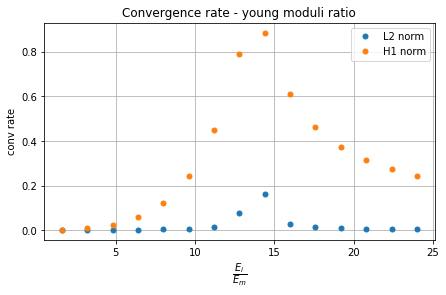

In [89]:
# plot convergence rate as a function of Young moduli ratio

plt.figure(figsize=(7,4))

Y_modulus_ratios = np.array([2.*i for i in range(1, 16)])*E_m

plt.plot(Y_modulus_ratios, conv_rate_L2_y, '.', markersize=10, label='L2 norm')
plt.plot(Y_modulus_ratios, conv_rate_H1_y, '.', markersize=10, label='H1 norm')

plt.title(r'Convergence rate - young moduli ratio')
plt.xlabel(r'$\dfrac{E_i}{E_m}$')
plt.ylabel('conv rate')

plt.grid(True)
plt.legend()

# plt.savefig('E.png')

The material properties once again have a high impact on the behavior of the system (observed through convergence rate).

**At this stage, one can see the convergence rate can be well studied but that one should run much more complex simulations, including variation of all parameters at the same time. We would then find new sets of values one can work with to ensure a good conv rate.**

#### ii. Geometry

In this part, we test behavior of numerical solution for different values of $\dfrac{R_m}{R_i}$ and shapes of ellipsoid.

##### radii ratio

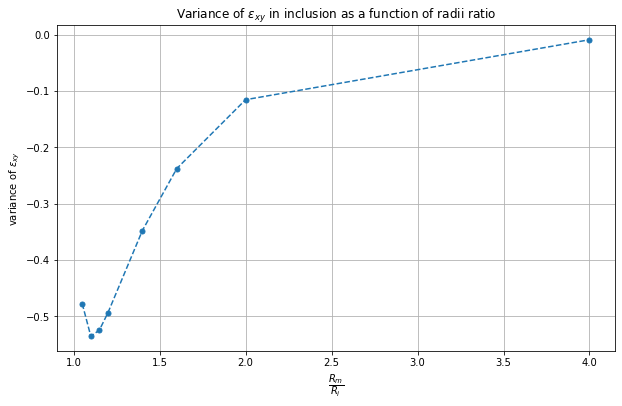

In [85]:
# plot deviation of inner strain as a function of radii ratio

plt.figure(figsize=(10,6))

ratio_radii = np.array([1.05, 1.1, 1.15, 1.2, 1.4, 1.6, 2.0, 4.0]) # can't change these values

plt.plot(ratio_radii, dev_strain_radii, '.--', markersize=10, label='L2 norm')

plt.title(r'Variance of $\epsilon_{xy}$ in inclusion as a function of radii ratio')
plt.xlabel('$\dfrac{R_m}{R_i}$')
plt.ylabel(r'variance of $\epsilon_{xy}$')

plt.grid(True)
# plt.savefig('radii.png')

One can see the bigger the ratio, namely the bigger $R_m$ compared to $R_i$, namely the more the imposed displacement are far from studied zone, the lower the deviation.

Then, in the limit case where the displacements are imposed at $R_m \rightarrow +\infty$, the inclusion isn't affected by the boundary condition and thereby presents a better homogeneity.

##### shape inclusion

### ANNEX : Equivalence Eshelby solution to Hill tensor?

In [ ]:
# Hill analytical solution ?
mu_m = E_m/(2*(1+nu_m))
mu_i = E_i/(2*(1+nu_i))
q    = (3-4*nu_m)/(8*mu_m*(1-nu_m))
b    = 1/(1+2*q*(mu_i-mu_m))
print('\n\u03B5_xy_inclusion ~= {:.3f}'.format(-b))

print('\n# --------------------------------- #\n')

#L2 error calculation
error = np.abs(-b - average_strain(eps_xy, dx, INCLUSION_ID)) / np.abs(-b)
print('relative error deviation : {:.2f}'.format(error*100), '%')

Comparing theory to num, one gets an error of $\approx 16.6 \%$. The error is quiet high